In [1]:
%matplotlib inline
from matplotlib.pylab import *

In [2]:
import numpy  as np
from PyGMRES.gmres import GMRES
from PyGMRES.linop import laplace_2d_dirichlet, laplace_2d_extrap, resid
from PyGMRES.compiler.numba import jit

In [3]:
import itertools
from   os.path import join
from   src_dir import Gauss_pdf_2D

In [4]:
# Set dimension of the NxN grid used
# Note: For optimal performance, the neural network "cnn_collectionOnline2D.py"
# can be tweaked with appropriate kernel dilations, however the code should
# still work and yield resuluts for any dimension of input provided
dim = 80

# Default initial guess used for direct un-preconditioned GMRES is the zero
# solution
x0 = np.squeeze(np.zeros((dim,dim)))
x0Type = 'Zero Solution 2D'

# Set tolerances for GMRES solver
e = 1e-10

# Restarted GMRES parameters
nmax_iter = 10
restart   = 10000

# Create domain [-1,1]x[-1,1]
# Define grid values at midpoints of cartesian grid
DomainL = -1.0
DomainR =  1.0
dx = (DomainR-DomainL)/(dim-1)
x1 = np.linspace(DomainL+dx,DomainR-dx,dim)
x2 = np.linspace(DomainL+dx,DomainR-dx,dim)
X, Y = np.meshgrid(x1, x2, sparse=False, indexing='ij')
Area = (dx*(dim-1))**2

# Create 2D laplace opertor as a stencil opertor for a N-cell 2D grid
# Can be found in linop.py in src_di
# @njit(nogil=True)
# def A_numba(x):
#     return laplace_2d_extrap(x)
A = laplace_2d_extrap
AType = '2D Laplacian'

# Total number of steps in simulation
n_steps = 100

In [5]:
def particle(X, Y, x, y, charge, sigma):
    b = charge*Gauss_pdf_2D(X, Y, x, y, sigma)
    b[0,  :] = 0
    b[-1, :] = 0
    b[:,  0] = 0
    b[:, -1] = 0
    return b

def force(dx, X, Y, phi_x, phi_y, x, y,sigma):
    weights = Gauss_pdf_2D(X, Y, x, y, sigma)
    return np.array([
        np.sum(phi_x*weights),
        np.sum(phi_y*weights)
    ])*dx**2

In [6]:
def time_step(mot, dt, dx, X, Y, p_0, v_0, p_lo, p_hi, charge, sigma):
    b = particle(X, Y, *p_0[0, :], charge[0], sigma)
    for i in range(1, len(charge)):
        b += particle(X, Y, *p_0[i, :], charge[i], sigma)
    
    Out = GMRES(A, b, x0, e, nmax_iter, restart, True)
    phi = Out[-1]
    # this is pretty powerful: https://numpy.org/doc/stable/reference/generated/numpy.gradient.html
    phi_x, phi_y = np.gradient(phi)
    
    p_1 = np.zeros_like(p_0)
    v_1 = np.zeros_like(v_0)
    for i in range(1, len(charge)):
        v_1[i, :] = v_0[i, :] + mot*dt*charge[i]*force(dx, X, Y, phi_x, phi_y, *p_0[i,:], sigma)
        p_1[i, :] = p_0[i, :] + dt*v_1[i,:]
        if p_1[i, 0] < p_lo:
            p_1[i, 0] = p_lo
            v_1[i, 0] = - v_1[i, 0]
        if p_1[i, 0] > p_hi:
            p_1[i, 0] = p_hi
            v_1[i, 0] = - v_1[i, 0]
        if p_1[i, 1] < p_lo:
            p_1[i, 1] = p_lo
            v_1[i, 1] = - v_1[i, 1]
        if p_1[i, 1] > p_hi:
            p_1[i, 1] = p_hi
            v_1[i, 1] = - v_1[i, 1]
    
    return p_1, v_1, b, phi, phi_x, phi_y

In [7]:
p_0 = np.random.rand(100, 2)*2 - 1

while True:

    charge = np.random.randint(low=0, high=2, size=(100,))
    if np.sum(charge) == 50:
        break

for i in range(len(charge)):
    if charge[i] == 0:
        charge[i] = -1


v_0 = np.zeros_like(p_0)

In [8]:
print(charge, sum(charge))

[-1 -1  1 -1  1 -1 -1  1  1  1  1 -1 -1 -1  1 -1  1 -1  1 -1 -1 -1  1 -1
 -1  1  1 -1 -1  1  1  1 -1 -1  1  1  1 -1  1  1  1 -1  1  1  1  1 -1  1
  1 -1 -1 -1  1  1  1  1 -1 -1 -1  1  1  1 -1  1 -1  1 -1  1  1  1 -1  1
 -1 -1 -1 -1 -1  1  1  1 -1  1 -1  1 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1
 -1  1  1  1] 0


In [9]:
p_0 = np.array([[-0.32336585,  0.65426417],
       [ 0.99695835, -0.55919024],
       [ 0.57414741, -0.70997247],
       [ 0.17239934, -0.19735975],
       [ 0.21289987,  0.91777169],
       [ 0.2290385 ,  0.52141195],
       [-0.461091  , -0.24082868],
       [ 0.87416939, -0.97180547],
       [ 0.27237462, -0.74976046],
       [-0.50083594,  0.9033211 ],
       [ 0.95405276,  0.66377531],
       [-0.19232476, -0.38316569],
       [-0.5439799 , -0.60119878],
       [-0.80170428,  0.97916761],
       [-0.35557476,  0.18080847],
       [ 0.12343328,  0.72446035],
       [ 0.68443256, -0.34386402],
       [-0.54183484,  0.20051936],
       [-0.96628812,  0.7855199 ],
       [-0.11312355, -0.20353866],
       [-0.07084636,  0.80498987],
       [-0.87940228,  0.90851145],
       [-0.92274332,  0.52025615],
       [-0.33131686,  0.62735958],
       [ 0.40828374, -0.80497079],
       [-0.75114389, -0.21967374],
       [-0.95222594,  0.02837373],
       [-0.17891211,  0.26456582],
       [ 0.49438066, -0.2020521 ],
       [ 0.40182937,  0.62828769],
       [ 0.45549344,  0.53066272],
       [-0.87058243,  0.22013615],
       [-0.21863544, -0.3763748 ],
       [-0.06603775, -0.32398507],
       [ 0.17563596, -0.96562274],
       [-0.02303948,  0.3975492 ],
       [ 0.80452177, -0.47469458],
       [-0.10035981, -0.64900091],
       [ 0.96789276, -0.07808388],
       [-0.77494789, -0.90276408],
       [-0.44588297, -0.79343323],
       [-0.31226309, -0.03770586],
       [ 0.00902535,  0.2977761 ],
       [ 0.96743835,  0.98858411],
       [-0.4831749 , -0.10956198],
       [ 0.90883782,  0.56429411],
       [ 0.26492572, -0.37334353],
       [-0.35562644,  0.46998845],
       [-0.60388658,  0.21206053],
       [ 0.50040838,  0.13853375],
       [-0.71692208, -0.08007318],
       [-0.18377235,  0.16617431],
       [-0.68823212, -0.54081855],
       [ 0.98189473,  0.92060401],
       [ 0.22325009, -0.62003679],
       [ 0.87203165, -0.72145588],
       [ 0.61022414,  0.71262689],
       [ 0.46341253, -0.73447958],
       [ 0.81620113,  0.14529449],
       [-0.65831043,  0.30633334],
       [ 0.67418208, -0.79153263],
       [ 0.09844183,  0.03423251],
       [-0.6495125 , -0.40122629],
       [ 0.42551474, -0.28821976],
       [ 0.17685578,  0.64124462],
       [ 0.02599516, -0.41685729],
       [-0.24631223,  0.93748552],
       [-0.76084879, -0.99073974],
       [-0.6911618 ,  0.16116393],
       [ 0.35523016,  0.31439847],
       [ 0.02702439,  0.23404171],
       [ 0.05170182, -0.63546815],
       [ 0.93602229, -0.0242043 ],
       [ 0.9654175 ,  0.91800482],
       [-0.32372887, -0.96158075],
       [-0.84864805, -0.88007476],
       [-0.30729487,  0.96725445],
       [ 0.74517372,  0.79475019],
       [ 0.22365847, -0.21456536],
       [ 0.31956092, -0.0195437 ],
       [-0.39823344,  0.42847733],
       [ 0.11316766, -0.2941797 ],
       [ 0.53542291,  0.58769601],
       [-0.56872265,  0.74768688],
       [-0.44041334, -0.18728935],
       [-0.6712288 ,  0.25742982],
       [-0.01247272, -0.43481363],
       [-0.06537395, -0.48134591],
       [-0.8709892 , -0.12702034],
       [-0.33199826, -0.41009277],
       [ 0.15986923, -0.05507174],
       [ 0.51295986,  0.28903897],
       [ 0.73006897, -0.99150382],
       [ 0.40915827,  0.9248435 ],
       [-0.8301332 ,  0.54186878],
       [ 0.86488576,  0.27373393],
       [ 0.08697332, -0.33076657],
       [-0.99978083, -0.07523161],
       [ 0.50554695,  0.59880198],
       [ 0.00522345,  0.58098295]])

charge = np.array([ 1,  1, -1,  1, -1, -1, -1,  1,  1,  1, -1,  1,  1, -1, -1,  1,  1,
       -1, -1, -1,  1, -1,  1,  1,  1, -1,  1,  1, -1, -1, -1, -1, -1,  1,
        1,  1,  1, -1,  1,  1, -1, -1, -1,  1, -1,  1,  1, -1, -1, -1,  1,
       -1,  1, -1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,
       -1,  1, -1,  1,  1, -1,  1, -1,  1, -1, -1, -1,  1, -1, -1,  1, -1,
       -1, -1,  1, -1,  1,  1,  1,  1, -1,  1,  1, -1, -1, -1, -1])

v_0 = np.zeros_like(p_0)

In [10]:
p_0 = np.array(
    [[0, 0],
     [-0.6, 0.6],
     [0.1, -0.5],
     [0.2, 0.5],
     [-0.1, 0.5],
     [-0.2, -0.5],
     [0.6, -0.6],
     [0.6, -0.2],
     [-0.75, -.25],
     [0.75, 0.75],
     [-0.25, 0.25],
     [0., 0.75],
     [-0.75, 0],
     [-0.75, -0.75]]
)
charge = np.array(
    [ 1,
     -1,
      1,
     -1,
     -1,
      1,
     -1,
      1,
      1,
     -1,
     -1,
      1,
      1,
     -1]
)
v_0 = np.zeros_like(p_0)

In [11]:
p_lo = DomainL
p_hi = DomainR

In [12]:
p_1, v_1, b_1, phi, phi_x, phi_y = time_step(1, 0, dx, X, Y, p_0, v_0, p_lo, p_hi, charge, 0.05)
# np.save(join("data", "X.npy"), X)
# np.save(join("data", "Y.npy"), Y)
# np.save(join("data", "b_1.npy"), b_1)
# np.save(join("data", "phi.npy"), phi)
# np.save(join("data", "phi_x.npy"), phi_x)
# np.save(join("data", "phi_y.npy"), phi_y)

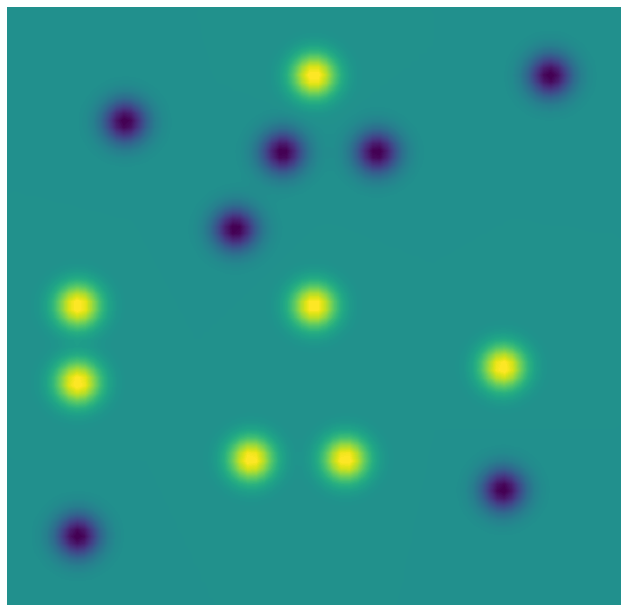

In [13]:
subplots(figsize=(11, 11))
cp = contourf(X, Y, b_1, levels=160, vmin=-60, vmax=60)
axis("off");

In [14]:
Out = GMRES(A, b_1, np.ones_like(phi), e, nmax_iter, restart, True)

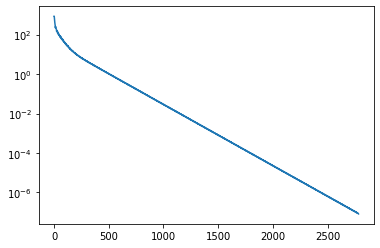

In [16]:
semilogy(resid(A, Out, b_1))

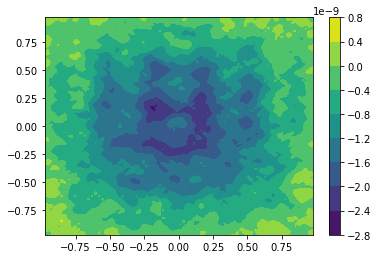

In [17]:
cp = contourf(X, Y, A(Out[-1]) - b_1)
colorbar(cp)

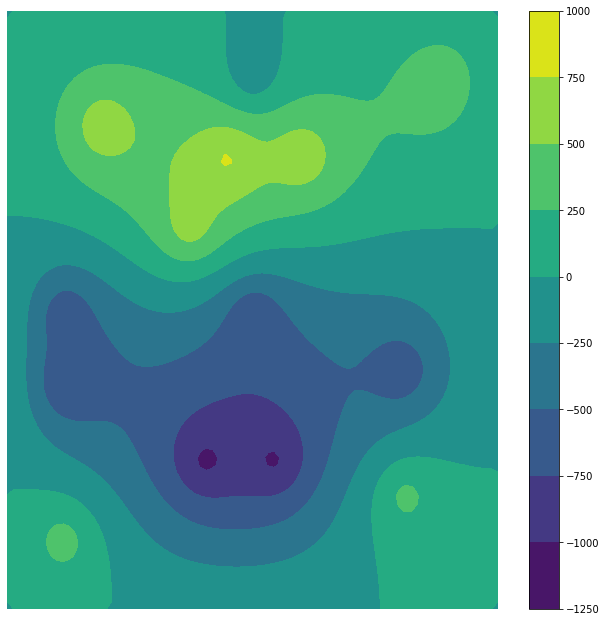

In [18]:
subplots(figsize=(11, 11))
cp = contourf(X, Y, phi)
colorbar(cp)
axis("off");

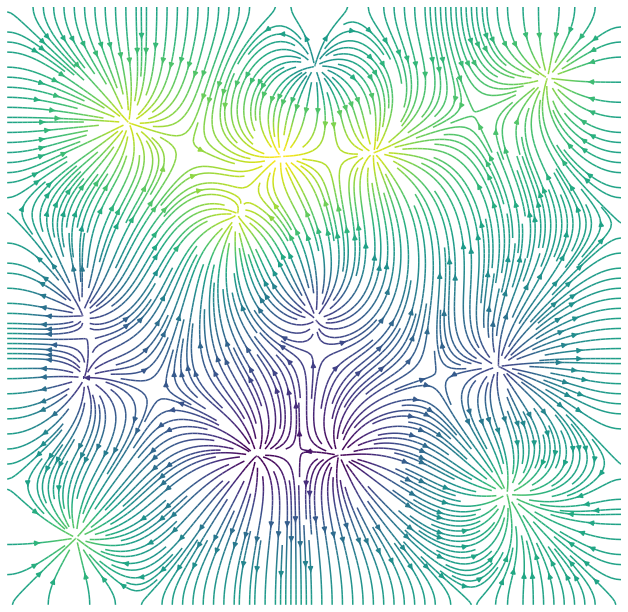

In [19]:
subplots(figsize=(11, 11))
# quiver(Y, X, phi_x, phi_y, scale_units='xy', scale=2e3)
streamplot(
    np.transpose(X), np.transpose(Y), np.transpose(phi_x), np.transpose(phi_y),
    color=np.transpose(phi), density=4
)
axis("off");

In [20]:
for i in range(10):
    print(i)
    p_1, v_1, b_2, phi, phi_x, phi_y = time_step(1, 1e-2, dx, X, Y, p_1, v_1, p_lo, p_hi, charge, 0.05)

# np.save(join("data", "b_2.npy"), b_2)

0
1
2
3
4
5
6
7
8
9


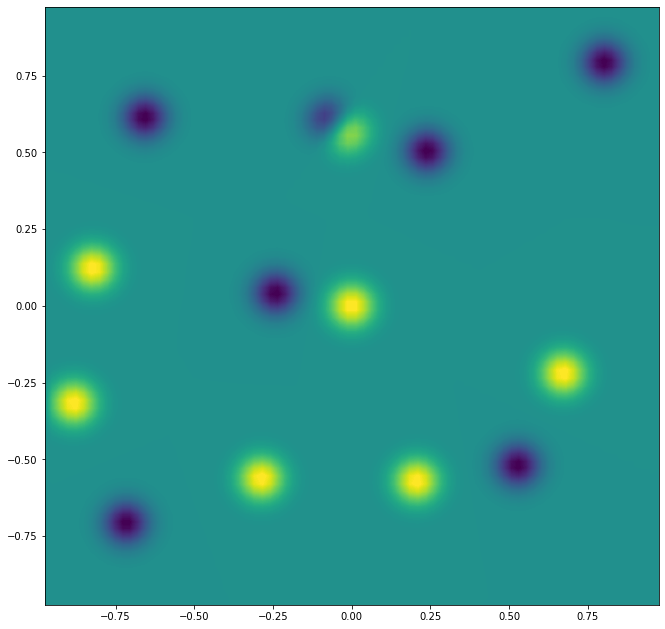

In [21]:
subplots(figsize=(11, 11))
cp = contourf(X, Y, b_2, levels=160, vmin=-60, vmax=60)
#axis("off");

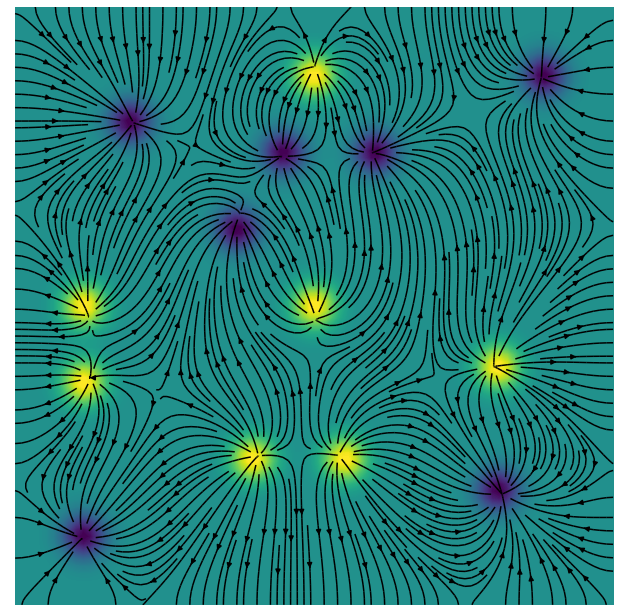

In [24]:
p_1, v_1, b, phi, phi_x, phi_y = time_step(0.5, 1e-3, dx, X, Y, p_0, v_0, p_lo, p_hi, charge, 0.05)
subplots(figsize=(11, 11))
cp = contourf(X, Y, b, levels=160, vmin=-60, vmax=60)
# quiver(Y, X, phi_x, phi_y, scale_units='xy', scale=2e3)
streamplot(
    np.transpose(X), np.transpose(Y), np.transpose(phi_x), np.transpose(phi_y),
    color="k", density=3
)
# colorbar(cp)
axis("off")
axis("equal");

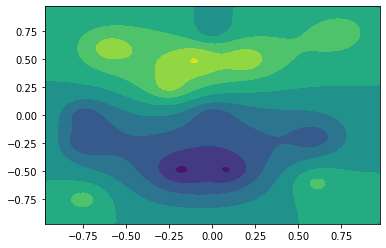

In [25]:
contourf(X, Y, phi)

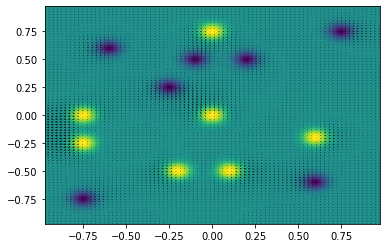

In [26]:
cp = contourf(X, Y, b_1, levels=160, vmin=-60, vmax=60)
quiver(X, Y, phi_x, phi_y, scale_units='xy', scale=5e3)

In [13]:
for i in range(768):
    p_1, v_1, b, phi, phi_x, phi_y = time_step(1, 1e-3, dx, X, Y, p_1, v_1, p_lo, p_hi, charge, 0.05)
    subplots(figsize=(11, 11))
    cp = contourf(X, Y, b, levels=160, vmin=-60, vmax=60)
    quiver(X, Y, phi_x, phi_y, scale_units='xy', scale=5e3)
    axis("off")
    axis("equal")
    savefig(join("vid", f"particles_{i:04d}.png"))
    close()

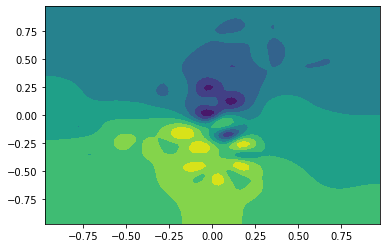

In [54]:
contourf(X, Y, phi)